In [1]:
import sys
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/src/compression')

from mps_ND import NDMPS
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import utils_ND as ut
import pickle
import json


/Users/maxge/miniconda3/envs/QEL/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [ ]:
def find_specific_files(directory_path, file_extension=None):
    """
    Finds all files in a directory with a specific file extension.
    """
    files = []
    for root, _, filenames in os.walk(directory_path):
        for filename in filenames:
            if file_extension is None or filename.endswith(file_extension):
                files.append(os.path.join(root, filename))
    return files

def load_tensors(files):
    """
    Loads the data from the file name list.
    """
    data_list = []
    for i, file in enumerate(files):
        print(f"Loading file {i+1}/{len(files)}")
        img = nib.load(file)
        img_data = img.get_fdata()
        data_list.append(img_data)
    return data_list

def conv_to_mps(data_list):
    """
    Conversts the data list to a list of MPS objects.
    """
    mps_list = []
    for i, data in enumerate(data_list):
        print(f"Converting file {i+1}/{len(data_list)}")
        mps = NDMPS.from_tensor(data, norm = False, mode="DCT")
        mps_list.append(mps)
    return mps_list

def conv_to_tensors(mps_list):
    data_list = []
    for i, mps in enumerate(mps_list):
        print(f"Converting file {i+1}/{len(mps_list)}")
        data = mps.to_tensor()
        data_list.append(data)
    return data_list

def load_mps(files):
    mps_list = []
    for i, file in enumerate(files):
        print(f"Loading file {i+1}/{len(files)}")
        img = nib.load(file)
        img_data = img.get_fdata()
        mps = mps = NDMPS.from_tensor(img_data, norm = False, mode="DCT")
        mps_list.append(mps)

    return mps_list

def compress_list(mps_list, compression_factors):
    for mps in mps_list:
        mps.compress(compression_factors)
    return None

def calc_compression_ratio(mps_list):
    compression_ratios = []
    for i, mps in enumerate(mps_list):
        compression_ratios.append(mps.compression_ratio())
    return compression_ratios

def benchmark_SSIM(mps_list, original_tensor_list):
    ssim_list = []
    for i, mps in enumerate(mps_list):
        ssim_list.append(ut.avg_SSIM_3D(mps.to_tensor(), original_tensor_list[i]))
    return ssim_list

def run_benchmark(mps_list, original_tensors_list, cutoff_list):
    ssim_list = []
    compressionratio_list = []
    compressionratio_list.append(calc_compression_ratio(mps_list))
    ssim_list.append(benchmark_SSIM(mps_list, original_tensors_list))
    for i, cutoff in enumerate(cutoff_list):
        print(i)
        compress_list(mps_list, cutoff)
        ssim_list.append(benchmark_SSIM(mps_list, original_tensors_list))
        compressionratio_list.append(calc_compression_ratio(mps_list))
    return np.array(ssim_list).T, np.array(compressionratio_list).T


def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [5]:
results_dict = {}

In [6]:
files = find_specific_files('/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset', ".gz")
results_dict["files"] = files

In [7]:
files

['/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-03_T1w.nii.gz',
 '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-12_T1w.nii.gz',
 '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-06_T1w.nii.gz',
 '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-01_T1w.nii.gz',
 '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-10_T1w.nii.gz',
 '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-09_T1w.nii.gz',
 '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-04_T1w.nii.gz',

In [9]:
data_list = load_tensors(files)

Loading file 1/13
Loading file 2/13
Loading file 3/13
Loading file 4/13
Loading file 5/13
Loading file 6/13
Loading file 7/13
Loading file 8/13
Loading file 9/13
Loading file 10/13
Loading file 11/13
Loading file 12/13
Loading file 13/13


In [10]:
mps_list = conv_to_mps(data_list)

Converting file 1/13


/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/src/compression/utils_ND.py:84: RuntimeWarning: invalid value encountered in cast
  prod_block_sizes[0] = prod_block_sizes[0] * 1e100


Converting file 2/13
Converting file 3/13
Converting file 4/13
Converting file 5/13
Converting file 6/13
Converting file 7/13
Converting file 8/13
Converting file 9/13
Converting file 10/13
Converting file 11/13
Converting file 12/13
Converting file 13/13


In [22]:
cutoff_list = np.linspace(0, 0.2, 20)[1:]
results_dict["cutoff_list"] = cutoff_list.tolist()

In [15]:
ssim_list, compressionratio_list = run_benchmark(mps_list, data_list, cutoff_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [23]:
results_dict["ssim_list"] = ssim_list.tolist()
results_dict["compressionratio_list"] = compressionratio_list.tolist()

In [24]:
results_dict

{'files': ['/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-03_T1w.nii.gz',
  '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-12_T1w.nii.gz',
  '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-06_T1w.nii.gz',
  '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-01_T1w.nii.gz',
  '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-10_T1w.nii.gz',
  '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub-09_T1w.nii.gz',
  '/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/Data/MRI Dataset/sub

In [ ]:
src/evaluation/results

In [27]:
with open('/Users/maxge/Documents/Studium/München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/src/evaluation/results/results_dict1.json', 'w') as fp:
    json.dump(results_dict, fp)

In [72]:
np.shape(compressionratio_list)

(13, 3)

In [60]:
np.array(ssim_list)[:,3]

array([0.99816133, 0.76922524, 0.52221449])

In [62]:
np.array(compressionratio_list)[:,3]

array([1.44562717, 1.17826742, 0.1727105 ])

In [74]:
ssim_list.shape[0]

13

In [75]:
np.arange(ssim_list.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [132]:
save_object(ssim_list, "ssim_list.pkl")
save_object(compressionratio_list, "compressionratio_list.pkl")

Text(0, 0.5, 'SSIM')

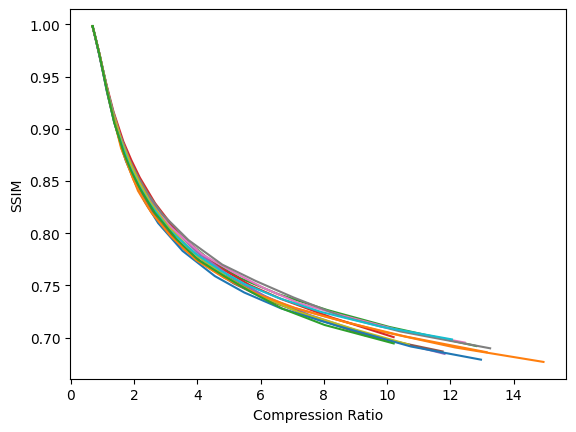

In [158]:
for i in np.arange(ssim_list.shape[0]):
    plt.plot(1/compressionratio_list[i,:20], ssim_list[i,:20], label=f"File {i+1}")

plt.xlabel("Compression Ratio")
plt.ylabel("SSIM")

In [128]:
cutoff_list[:40]

array([0.00481928, 0.00963855, 0.01445783, 0.01927711, 0.02409639,
       0.02891566, 0.03373494, 0.03855422, 0.04337349, 0.04819277,
       0.05301205, 0.05783133, 0.0626506 , 0.06746988, 0.07228916,
       0.07710843, 0.08192771, 0.08674699, 0.09156627, 0.09638554,
       0.10120482, 0.1060241 , 0.11084337, 0.11566265, 0.12048193,
       0.1253012 , 0.13012048, 0.13493976, 0.13975904, 0.14457831,
       0.14939759, 0.15421687, 0.15903614, 0.16385542, 0.1686747 ,
       0.17349398, 0.17831325, 0.18313253, 0.18795181, 0.19277108])

In [9]:
for mps in mps_list:
    print(mps.compression_ratio())

1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889
1.445627170138889


In [157]:
mps_list[3].mps.bond_size(1,2)

1

In [ ]:
recovered_img_0 = mps_list[0].mps_to_matrix()
recovered_img_1 = mps_list[1].mps_to_matrix()

In [ ]:
def data_loader(data_path):
    data = nib.load(data_path).get_fdata()
    return data

In [ ]:
mri_file = './MRI Dataset/sub-01_T1w.nii.gz'
img = nib.load(mri_file)

In [ ]:
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

<class 'numpy.ndarray'>
(160, 192, 192)


(192, 192)


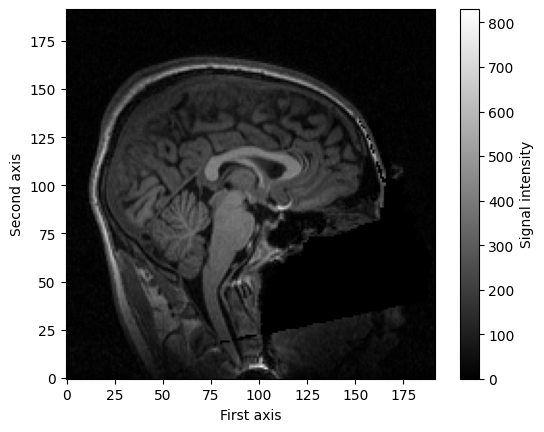

In [ ]:
mid_slice_x = img_data[80, :, :]
print(mid_slice_x.shape)
# Note that the transpose the slice (using the .T attribute).
# This is because imshow plots the first dimension on the y-axis and the
# second on the x-axis, but we'd like to plot the first on the x-axis and the
# second on the y-axis. Also, the origin to "lower", as the data was saved in
# "cartesian" coordinates.
plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

In [ ]:
mps = NDMPS.from_matrix(img_data, norm = False, mode="DCT")

Time to run balance_factors: 0.0000 seconds
Time to run balance_factors: 0.0000 seconds


In [ ]:
mps.compression_ratio()

np.float64(1.445627170138889)

In [ ]:
mps.continuous_compress(0.08)

Compression ratio at 0.0008: 1.445627170138889
Compression ratio at 0.004: 1.445627170138889
Compression ratio at 0.008: 1.445627170138889
Compression ratio at 0.016: 1.3900282118055556
Compression ratio at 0.04: 0.5589009602864583
Compression ratio at 0.064: 0.24091118706597223
Compression ratio at 0.08: 0.12302042643229166


In [ ]:
mps.compression_ratio()

np.float64(0.12302042643229166)

In [ ]:
recovered_img = mps.mps_to_matrix()

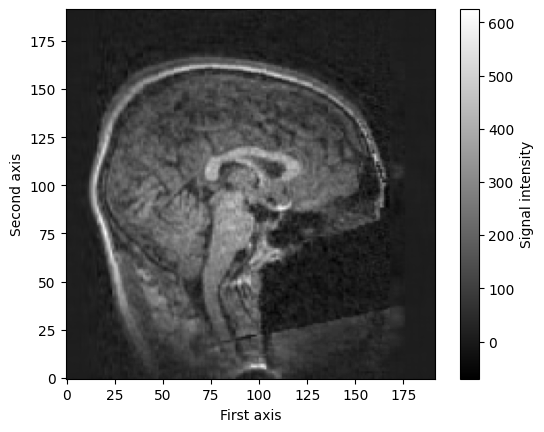

In [ ]:
plt.imshow(recovered_img[80,:,:].T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

In [ ]:
from utils import rescale_image

In [ ]:
a = np.array([-5,4])
b = np.array([0,4])
min = np.min(b)
max = np.max(b)
def rescale_data(data, min, max):
    data_min = np.min(data)
    data_max = np.max(data)
    data = min + (max - min) / (data_max - data_min) * (data - data_min)
    return data

In [ ]:
rescale_data(a, min, max)

array([0., 4.])